In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from imageio import imread, imwrite
from tqdm import tqdm, trange

/var/folders/p0/33dk45cj5032325pzfbs9vhh0000gn/T/ipykernel_23138/1482734462.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('Broadway_tower_edit.jpg')


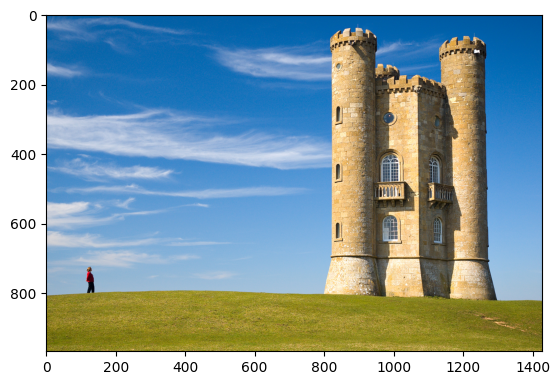

In [17]:
# load example.jpg
img = imread('Broadway_tower_edit.jpg')
plt.imshow(img)

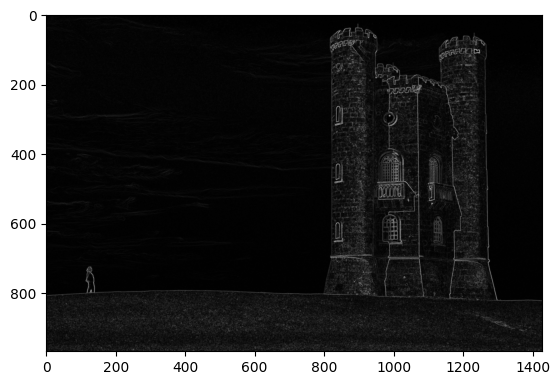

In [18]:
# calculate energy value for each pixel
def calculate_energy(img):
    du_filter = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0]
    ])
    dv_filter = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0]
    ])
    du_filter = np.stack([du_filter] * 3, axis=2)
    dv_filter = np.stack([dv_filter] * 3, axis=2)
    img = np.array(img).astype('float32')
    convolved = np.abs(convolve(img, du_filter)) + np.abs(convolve(img, dv_filter))
    energy_map = convolved.sum(axis=2)
    return energy_map

# example:
energy_map = calculate_energy(img)
plt.imshow(energy_map, cmap='gray')

In [19]:
def min_seam(img):
    row, col, _ = img.shape
    energy_map = calculate_energy(img)
    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=int)

    for i in range(1, row):
        for j in range(0, col):
            if j == 0:
                idx = np.argmin(M[i - 1, j : j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1 : j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]
            M[i, j] += min_energy

    return M, backtrack

In [20]:
def carve_col(img):
    row, col, _ = img.shape
    M, backtrack = min_seam(img)
    mask = np.ones((row, col), dtype=bool)
    j = np.argmin(M[-1])
    for i in range(row-1, -1, -1):
        mask[i, j] = False
        j = backtrack[i, j]
    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((row, col-1, 3))
    return img

def crop_col(img, scale_c):
    row, col, _ = img.shape
    new_col = int(col * scale_c)
    for i in trange(col - new_col):
        img = carve_col(img)
    return img

img = imread('example.jpg')
img = crop_col(img, 0.5)
plt.imshow(img)

/var/folders/p0/33dk45cj5032325pzfbs9vhh0000gn/T/ipykernel_23138/1776928343.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('example.jpg')
 14%|█▍        | 143/1024 [13:10<1:26:11,  5.87s/it]